This kernel is:
- Based on [Very fst Model](https://www.kaggle.com/ragnar123/very-fst-model). Thanks [@ragnar123](https://www.kaggle.com/ragnar123).
- Automatically uploaded by [push-kaggle-kernel](https://github.com/harupy/push-kaggle-kernel).
- Formatted by [Black](https://github.com/psf/black).

# Objective

* Make a baseline model that predict the validation (28 days).
* This competition has 2 stages, so the main objective is to make a model that can predict the demand for the next 28 days.

In [1]:
import gc
import os
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from fastai import *
from fastai.tabular import *
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

In [2]:
from imports import *
from structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [3]:
import IPython


def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
def read_data():
    INPUT_DIR = "/home/shanmugam/fastai/m5"

    print("Reading files...")

    calendar = pd.read_csv(f"{INPUT_DIR}/calendar.csv").pipe(reduce_mem_usage)
    sell_prices = pd.read_csv(f"{INPUT_DIR}/sell_prices.csv").pipe(reduce_mem_usage)

    # Limit the number of columns to use to prevent OOM error.
    sales_train_val = pd.read_csv(f"{INPUT_DIR}/sales_train_validation.csv",).pipe(
        reduce_mem_usage
    )
    submission = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv").pipe(
        reduce_mem_usage
    )

    print("Calendar shape:", calendar.shape)
    print("Sell prices shape:", sell_prices.shape)
    print("Sales train shape:", sales_train_val.shape)
    print("Submission shape:", submission.shape)

    return calendar, sell_prices, sales_train_val, submission

In [4]:
calendar, sell_prices, sales_train_val, submission = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)
Calendar shape: (1969, 14)
Sell prices shape: (6841121, 4)
Sales train shape: (30490, 1919)
Submission shape: (60980, 29)


In [6]:
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As [@kaushal2896](https://www.kaggle.com/kaushal2896) suggested in [this comment](https://www.kaggle.com/harupy/m5-baseline#770558), encode the categorical columns before merging to prevent the notebook from crashing even with the full dataset.

In [7]:
def encode_categorical(df, cols, fillna=False):
    for col in cols:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(
            df[col].fillna("MISSING") if fillna else df[col]
        )
    return df


calendar = encode_categorical(
    calendar,
    ["event_name_1", "event_type_1", "event_name_2", "event_type_2"],
    fillna=True,
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)

Mem. usage decreased to  0.07 Mb (43.0% reduction)
Mem. usage decreased to 94.01 Mb (1.0% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


In [8]:
def melt(
    sales_train_val, submission, nrows=55_000_000, verbose=True,
):
    # melt sales data, get it ready for training
    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
    sales_train_val = pd.melt(
        sales_train_val, id_vars=id_columns, var_name="day", value_name="demand",
    )

    sales_train_val = reduce_mem_usage(sales_train_val)

    if verbose:
        print("After melt")
        display(sales_train_val)

    # separate test dataframes.
    test1 = submission[submission["id"].str.endswith("validation")]
    test2 = submission[submission["id"].str.endswith("evaluation")]

    # change column names.
    test1.columns = ["id"] + [f"d_{x}".format(x) for x in range(1914, 1914 + 28)]
    test2.columns = ["id"] + [f"d_{x}".format(x) for x in range(1942, 1942 + 28)]

    # get product table.
    product = sales_train_val[id_columns].drop_duplicates()

    # merge with product table
    test2["id"] = test2["id"].str.replace("_evaluation", "_validation")
    test1 = test1.merge(product, how="left", on="id")
    test2 = test2.merge(product, how="left", on="id")
    test2["id"] = test2["id"].str.replace("_validation", "_evaluation")

    if verbose:
        print("test1 & 2")
        display(test1, test2)

    test1 = pd.melt(test1, id_vars=id_columns, var_name="day", value_name="demand")
    test2 = pd.melt(test2, id_vars=id_columns, var_name="day", value_name="demand")

    sales_train_val["part"] = "train"
    test1["part"] = "test1"
    test2["part"] = "test2"
    
    
    data = pd.concat([sales_train_val, test1, test2], axis=0)

    del sales_train_val, test1, test2

    # get only a sample for fast training.
#     data = data.loc[nrows:]

    # delete test2 for now.
    data = data[data["part"] != "test2"]

    gc.collect()

    if verbose:
        print("data")
        display(data)

    return data


def merge_calendar(data, calendar, verbose=True):
    # drop some calendar features.
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)

    # notebook crashes with the entire dataset.
    data = pd.merge(data, calendar, how="left", left_on=["day"], right_on=["d"])
    data = data.drop(["d", "day"], axis=1)
    
    data1 = data[(data['date'] > '2016-03-27')]
    data = data.drop(data.index[(list(range(57473650,59181090)))])
    data = data[data.demand != 0]
    data = pd.concat([data, data1], axis=0)
    del data1
    if verbose:
        print("with calendar merged")
        display(data)

    return data


def merge_sell_prices(data, sell_prices, verbose=True):
    # get the sell price data (this feature should be very important).
    data = data.merge(sell_prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")

    if verbose:
        print("with sell_prices merged")
        display(data)

    return data

In [9]:
data = melt(sales_train_val, submission, nrows=10_100_000)
del sales_train_val
gc.collect()

data = merge_calendar(data, calendar)
del calendar
gc.collect()

data = merge_sell_prices(data, sell_prices)
del sell_prices
gc.collect()

data = reduce_mem_usage(data)

Mem. usage decreased to 1335.01 Mb (0.0% reduction)
After melt


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0


test1 & 2


,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0


data


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0,train
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0,train
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0,train
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0,train
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0,train


with calendar merged


,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
7,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,12,train,2011-01-29,11101,13,1,3,1,0,0,0
8,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,2,train,2011-01-29,11101,13,1,3,1,0,0,0
14,HOBBIES_1_015_CA_1_validation,1451,3,1,0,0,4,train,2011-01-29,11101,13,1,3,1,0,0,0
15,HOBBIES_1_016_CA_1_validation,1452,3,1,0,0,5,train,2011-01-29,11101,13,1,3,1,0,0,0
21,HOBBIES_1_022_CA_1_validation,1458,3,1,0,0,2,train,2011-01-29,11101,13,1,3,1,0,0,0


with sell_prices merged


,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,12,train,2011-01-29,11101,13,1,3,1,0,0,0,0.459961
1,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,2,train,2011-01-29,11101,13,1,3,1,0,0,0,1.559570
2,HOBBIES_1_015_CA_1_validation,1451,3,1,0,0,4,train,2011-01-29,11101,13,1,3,1,0,0,0,0.700195
3,HOBBIES_1_016_CA_1_validation,1452,3,1,0,0,5,train,2011-01-29,11101,13,1,3,1,0,0,0,0.700195
4,HOBBIES_1_022_CA_1_validation,1458,3,1,0,0,2,train,2011-01-29,11101,13,1,3,1,0,0,0,6.859375


Mem. usage decreased to 967.13 Mb (0.0% reduction)


In [ ]:
def add_agg_features(df):
    # rolling demand features.
    for shift in [28, 29, 30]:
        df[f"shift_t{shift}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(shift)
        )

    for size in [7, 30]:
        df[f"rolling_std_t{size}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(28).rolling(size).std()
        )
    df = reduce_mem_usage(df)
    gc.collect()
    for size in [7, 30, 90, 180]:
        df[f"rolling_mean_t{size}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(28).rolling(size).mean()
        )

    df["rolling_skew_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(28).rolling(30).skew()
    )
    df["rolling_kurt_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(28).rolling(30).kurt()
    )
    df = reduce_mem_usage(df)
    gc.collect()
    # price features
    df["shift_price_t1"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        df["shift_price_t1"]
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["rolling_price_max_t365"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (
        df["rolling_price_max_t365"]
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["rolling_price_std_t7"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(7).std()
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["rolling_price_std_t30"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(30).std()
    )
    df = reduce_mem_usage(df)
    gc.collect()
    return df.drop(["rolling_price_max_t365", "shift_price_t1"], axis=1)


def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = ["year", "month", "week", "day", "dayofweek"]
    for attr in attrs:
        df[attr] = getattr(df[dt_col], attr)

    df["is_weekend"] = df["dayofweek"].isin([5, 6])
    return df

In [ ]:
data = add_agg_features(data)

In [ ]:
data = reduce_mem_usage(data)

data = pd.read_feather('/home/shanmugam/fastai/m5/fin_data').pipe(reduce_mem_usage)
gc.collect()

In [28]:
[i for i in list(data.columns) if i not in features]

['date',
 'id',
 'part',
 'sell_price_na',
 'sell_price_rel_diff_na',
 'sell_price_roll_sd7_na',
 'sell_price_cumrel_na',
 'demand']

In [11]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # aggregation features.
    "shift_t28",
#     "shift_t29",
#     "shift_t30",
    "rolling_mean_t7",
    "rolling_std_t7",
    "rolling_mean_t30",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_std_t30",
#     "price_change_t1",
#     "price_change_t365",
#     "rolling_price_std_t7",
#     "rolling_price_std_t30",
#     "rolling_skew_t30",
#     "rolling_kurt_t30",
        "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend", 
    
    "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel"
#             "lag_t28"
#     'Month', 'Week', 'Day', 'Dayofweek','Dayofyear','Is_month_end','is_weekend','Is_month_start','Is_quarter_end','Is_quarter_start',
#         'Is_year_end','Is_year_start'
]
delete = ["shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_mean_t7",
    "rolling_std_t7",
    "rolling_mean_t30",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_std_t30",
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    "rolling_skew_t30",
    "rolling_kurt_t30",
         "year",
    "month",
    "week",
    "day",
    "dayofweek"]
# cat_ch = [(c, len(data[c].value_counts())) for c in features]
# cat_ch

In [12]:
cat_m = ['snap_WI', 'snap_TX', 'snap_CA', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'week', 'day', 'dayofweek', 'year', 'is_weekend']#,'Dayofyear','Is_month_end','is_weekend','Is_month_start','Is_quarter_end','Is_quarter_start',
#         'Is_year_end','Is_year_start']
# cat_m = ["item_id",
#     "dept_id",
#     "cat_id",
#     "store_id",
#     "state_id",
#     "event_name_1",
#     "event_type_1",
#     "event_name_2",
#     "event_type_2",
#     "snap_CA",
#     "snap_TX",
#     "snap_WI",
#         "year",
#     "month",
#     "week",
#     "day",
#     "dayofweek",
#     'is_weekend']
cont = [x for x in features if x not in cat_m]
# cont = []
# cat_m = [x for x in features if x not in cont]

procs = [Categorify]

cont

['sell_price',
 'shift_t28',
 'rolling_mean_t7',
 'rolling_std_t7',
 'rolling_mean_t30',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'rolling_std_t30',
 'sell_price_rel_diff',
 'sell_price_roll_sd7',
 'sell_price_cumrel']

In [13]:
df = data[cont].copy()

In [14]:
df = df.astype('float32', errors='ignore')

In [ ]:
df.info()

In [16]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
def fix_missing(df, col, name, na_dict):
    
    if is_numeric_dtype(col):
        
        if pd.isnull(col).sum() or (name in na_dict):
                df[name+'_na'] = pd.isnull(col)
                filler = na_dict[name] if name in na_dict else col.median()
                df[name] = col.fillna(filler)
                na_dict[name] = filler
    return na_dict

In [17]:
na_dict = {}
na_dict_initial = na_dict.copy()
for n,c in df.items():
    na_dict = fix_missing(df, c, n, na_dict)
df.drop([a + '_na' for a in list(set(na_dict.keys())) ], axis=1, inplace=True)
na_dict

{}

In [15]:
means,stds = {},{}
min1,max1 = {},{}
for n in cont:
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])

#     values = df[n].values
#     values = values.reshape((len(values), 1))
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaler = scaler.fit(values)
#     normalized = scaler.transform(values)
#     data[n] = normalized

#       min1[n],max1[n] = df[n].min(),df[n].max()
#       df[n] = (df[n] - min1[n]) / (df[n].max() - df[n].min())

In [16]:
# data.drop(delete, axis=1, inplace=True)
data.drop(cont, axis=1, inplace=True)

In [17]:
for c in cont:
    data[cont] = df[cont]

In [18]:
data = reduce_mem_usage(data)

Mem. usage decreased to 1739.19 Mb (46.5% reduction)


In [19]:
del df

In [20]:
gc.collect()

100

In [22]:
?add_datepart

In [21]:
data

,date,id,item_id,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,year,month,week,day,dayofweek,is_weekend,demand,sell_price,shift_t28,rolling_mean_t7,rolling_std_t7,rolling_mean_t30,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,2014-03-28,HOBBIES_1_001_CA_1_validation,1438,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,1.246094,-0.346924,-0.246582,-0.118347,-0.250732,-0.229614,-0.218384,-0.225220,-0.120178,-0.429199,-0.593262
1,2014-03-28,HOBBIES_1_002_CA_1_validation,1439,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,-0.007603,-0.346924,-0.389160,-0.606934,-0.367188,-0.354248,-0.361572,-0.476074,-0.120178,-0.429199,-0.593262
2,2014-03-28,HOBBIES_1_003_CA_1_validation,1440,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,-0.300049,-0.346924,-0.389160,-0.606934,-0.273926,-0.366211,-0.390137,-0.230957,-0.120178,-0.429199,-0.593262
3,2014-03-28,HOBBIES_1_004_CA_1_validation,1441,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,2.0,0.188354,0.809082,0.799316,1.875000,0.412842,0.429932,0.386230,0.848145,-0.120178,-0.429199,-0.593262
4,2014-03-28,HOBBIES_1_005_CA_1_validation,1442,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,1.0,-0.268066,-0.346924,-0.151489,-0.016068,-0.099426,-0.092773,-0.063049,-0.101196,-0.120178,-0.429199,-0.593262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995625,2016-05-22,FOODS_3_823_WI_3_validation,1433,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,-0.297363,-0.057953,-0.294189,-0.303955,-0.332275,-0.253662,-0.185791,-0.330322,-0.120178,-0.429199,0.807129
23995626,2016-05-22,FOODS_3_824_WI_3_validation,1434,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,-0.443604,-0.346924,-0.341553,-0.372314,-0.297363,-0.374268,-0.394287,-0.339600,-0.120178,-0.429199,0.609375
23995627,2016-05-22,FOODS_3_825_WI_3_validation,1435,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,-0.004749,-0.346924,-0.199097,-0.118347,-0.099426,-0.084839,-0.132568,0.017273,-0.120178,-0.429199,-0.593262
23995628,2016-05-22,FOODS_3_826_WI_3_validation,1436,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,-0.794434,0.520020,-0.009033,0.228516,-0.029724,-0.040497,0.079895,0.038727,-0.120178,-0.429199,-0.593262


In [13]:
add_datepart(data,'date', drop=False)

In [14]:
data = reduce_mem_usage(data)
gc.collect()

Mem. usage decreased to 1308.47 Mb (38.9% reduction)


70

In [ ]:
data.drop(['Elapsed'], axis=1, inplace=True)

In [15]:
data["is_weekend"] = data["Dayofweek"].isin([5, 6])
data = reduce_mem_usage(data)
gc.collect()

Mem. usage decreased to 1327.43 Mb (0.0% reduction)


20

data.astype('float32', errors='ignore').to_feather('data_min_all147')

In [41]:
data[(data['date'] > '2016-03-27') & (data['date'] < '2016-04-25')]

,date,id,part,item_id,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,year,month,week,day,dayofweek,is_weekend,sell_price_na,sell_price_rel_diff_na,sell_price_roll_sd7_na,sell_price_cumrel_na,demand,sell_price,shift_t28,rolling_mean_t7,rolling_std_t7,rolling_mean_t30,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
22288190,2016-03-28,HOBBIES_1_001_CA_1_validation,train,1438,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,3.0,13.0,28.0,0.0,0.0,False,False,False,False,1.0,1.246094,-0.346924,-0.009033,0.302490,-0.052887,-0.108887,-0.151123,0.073486,-0.120178,-0.429199,-0.593262
22288191,2016-03-28,HOBBIES_1_002_CA_1_validation,train,1439,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,3.0,13.0,28.0,0.0,0.0,False,False,False,False,1.0,-0.007603,-0.346924,-0.341553,-0.372314,-0.343750,-0.265869,-0.277588,-0.432129,-0.120178,-0.429199,-0.593262
22288192,2016-03-28,HOBBIES_1_003_CA_1_validation,train,1440,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,3.0,13.0,28.0,0.0,0.0,False,False,False,False,0.0,-0.300049,-0.346924,-0.389160,-0.606934,-0.297363,-0.173218,-0.169434,-0.380615,-0.120178,-0.429199,-0.593262
22288193,2016-03-28,HOBBIES_1_004_CA_1_validation,train,1441,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,3.0,13.0,28.0,0.0,0.0,False,False,False,False,0.0,0.188354,-0.346924,0.228760,0.707031,0.365723,0.284912,0.280273,0.502930,-0.120178,-0.429199,-0.593262
22288194,2016-03-28,HOBBIES_1_005_CA_1_validation,train,1442,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,3.0,13.0,28.0,0.0,0.0,False,False,False,False,1.0,-0.326416,-0.057953,-0.056458,0.014275,-0.006195,-0.012573,0.024597,0.117493,-0.120178,-0.429199,-0.593262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23141905,2016-04-24,FOODS_3_823_WI_3_validation,train,1433,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,4.0,16.0,24.0,6.0,1.0,False,False,False,False,1.0,-0.297363,-0.346924,-0.389160,-0.606934,-0.308838,-0.189331,-0.163330,-0.311035,-0.120178,-0.429199,0.807129
23141906,2016-04-24,FOODS_3_824_WI_3_validation,train,1434,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,4.0,16.0,24.0,6.0,1.0,False,False,False,False,0.0,-0.443604,-0.346924,-0.389160,-0.606934,-0.402100,-0.410645,-0.412598,-0.657227,-0.120178,-0.429199,0.609375
23141907,2016-04-24,FOODS_3_825_WI_3_validation,train,1435,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,4.0,16.0,24.0,6.0,1.0,False,False,False,False,0.0,-0.004749,-0.057953,-0.151489,-0.016068,0.028580,-0.084839,-0.177612,-0.102356,-0.120178,-0.429199,-0.593262
23141908,2016-04-24,FOODS_3_826_WI_3_validation,train,1436,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,4.0,16.0,24.0,6.0,1.0,False,False,False,False,3.0,-0.794434,0.809082,0.133545,0.183594,0.005398,0.019592,0.104370,-0.013435,-0.120178,-0.429199,-0.593262


In [11]:
data

,date,id,part,item_id,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,year,month,week,day,dayofweek,is_weekend,shift_t28,rolling_std_t7,rolling_std_t30,rolling_mean_t7,rolling_mean_t30,rolling_mean_t90,rolling_mean_t180,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel,demand
0,2014-03-28,HOBBIES_1_001_CA_1_validation,train,1438,4,1,1,1,14,2,1,1,0.0,0.0,0.0,8.257812,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,0.786621,0.728027,0.428467,0.433350,0.500000,0.527832,0.0,0.0,0.000000,0.0
1,2014-03-28,HOBBIES_1_002_CA_1_validation,train,1439,4,1,1,1,14,2,1,1,0.0,0.0,0.0,3.970703,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,0.000000,0.305176,0.000000,0.099976,0.155518,0.138916,0.0,0.0,0.000000,0.0
2,2014-03-28,HOBBIES_1_003_CA_1_validation,train,1440,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2.970703,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,0.000000,0.718262,0.000000,0.366699,0.122192,0.061096,0.0,0.0,0.000000,0.0
3,2014-03-28,HOBBIES_1_004_CA_1_validation,train,1441,4,1,1,1,14,2,1,1,0.0,0.0,0.0,4.640625,2014.0,3.0,13.0,28.0,4.0,0.0,4.0,3.994141,2.537109,3.572266,2.333984,2.322266,2.171875,0.0,0.0,0.000000,2.0
4,2014-03-28,HOBBIES_1_005_CA_1_validation,train,1442,4,1,1,1,14,2,1,1,0.0,0.0,0.0,3.080078,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,0.951172,0.937012,0.714355,0.866699,0.877930,0.950195,0.0,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995625,2016-05-22,FOODS_3_823_WI_3_validation,test1,1433,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2.980469,2016.0,5.0,20.0,22.0,6.0,1.0,1.0,0.488037,0.550781,0.285645,0.199951,0.433350,0.616699,0.0,0.0,0.333252,0.0
23995626,2016-05-22,FOODS_3_824_WI_3_validation,test1,1434,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2.480469,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,0.377930,0.535156,0.142822,0.300049,0.099976,0.049988,0.0,0.0,0.286133,0.0
23995627,2016-05-22,FOODS_3_825_WI_3_validation,test1,1435,3,0,10,3,14,2,1,1,0.0,0.0,0.0,3.980469,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,0.786621,1.136719,0.571289,0.866699,0.899902,0.761230,0.0,0.0,0.000000,0.0
23995628,2016-05-22,FOODS_3_826_WI_3_validation,test1,1436,3,0,10,3,14,2,1,1,0.0,0.0,0.0,1.280273,2016.0,5.0,20.0,22.0,6.0,1.0,3.0,1.344727,1.172852,1.142578,1.066406,1.022461,1.338867,0.0,0.0,0.000000,0.0


In [9]:
data.astype('float32', errors='ignore').to_feather('data_min_all143d')

In [4]:
data = pd.read_feather('/home/shanmugam/fastai/m5/data_min_all143d').pipe(reduce_mem_usage)

Mem. usage decreased to 1968.03 Mb (41.9% reduction)


In [21]:
use_cols = [
#     'id',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
#  'demand',
#  'part',
#  'date',
#  'wm_yr_wk',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
#  'snap_CA',
#  'snap_TX',
#  'snap_WI',
 'sell_price',
 'year',
 'month',
 'week',
 'day',
 'dayofweek',
 'is_weekend',
 'shift_t28',
 'rolling_std_t7',
 'rolling_std_t30',
 'rolling_mean_t7',
 'rolling_mean_t30',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'sell_price_rel_diff',
 'sell_price_roll_sd7',
 'sell_price_cumrel']

In [22]:
train_df = data.iloc[:22288190].copy()
valid_df = data.iloc[22288190:23141910].copy()
test_df = data.iloc[23141910:].copy()
del data
gc.collect()

40

In [23]:
train = np.array(list(train_df[train_df['part']=='train'].groupby('id').apply(lambda x: x[use_cols].values)))

In [24]:
val = np.array(list(valid_df[valid_df['part']=='train'].groupby('id').apply(lambda x: x[use_cols].values)))

In [25]:
test = np.array(list(test_df.groupby('id').apply(lambda x: x[use_cols].values)))

In [54]:
train_y = np.array(list(train_df[train_df['part']=='train'].groupby('id').apply(lambda x: x[['demand']].values)))
val_y = np.array(list(valid_df[valid_df['part']=='train'].groupby('id').apply(lambda x: x[['demand']].values)))

In [27]:
train = train.transpose((0,2,1))
val = val.transpose((0,2,1))
test = test.transpose((0,2,1))

In [66]:
class Seq2SeqRnn(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, output_size, num_layers=1, bidirectional=False, dropout=.3,
            hidden_layers = [100, 200]):
        
        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.num_layers=num_layers
        self.bidirectional=bidirectional
        self.output_size=output_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                           bidirectional=bidirectional, batch_first=True,dropout=0.5)
#         self.relu = [nn.ReLU(inplace=True)]
        self.bn = BatchNorm1dFlat(hidden_size*2)
        
         # Input Layer
        if hidden_layers and len(hidden_layers):
            
#             first_layer  = nn.Linear(hidden_size*2 if bidirectional else hidden_size, hidden_layers[0])
            first_layer  = nn.Linear(hidden_size*2 if bidirectional else hidden_size, hidden_layers[0])

            # Hidden Layers
#             for i in range(len(hidden_layers) - 1):
#                 self.hidden_layers = nn.ModuleList(
#                     [first_layer]+ [nn.ReLU] + [BatchNorm1dFlat(hidden_layers[i])] + [nn.Linear(hidden_layers[i], hidden_layers[i+1])] 
#                 )
            self.hidden_layers = nn.ModuleList(
                [first_layer]+[nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers) - 1)]
            )
#             nn.init.kaiming_normal_(self.hidden_layers[0].weight.data)   
#             nn.init.kaiming_normal_(self.hidden_layers[3].weight.data)  
            for layer in self.hidden_layers: nn.init.kaiming_normal_(layer.weight.data) 
            self.intermediate_layer = nn.Linear(hidden_layers[-1], self.input_size)
#             self.intermediate_layer = nn.ModuleList([nn.ReLU] + 
#                 [BatchNorm1dFlat(hidden_layers[-1])] + [nn.Linear(hidden_layers[-1], self.input_size)])
#             output layers
#             self.output_layer = nn.ModuleList([nn.ReLU] + [BatchNorm1dFlat(hidden_layers[-1])] + [nn.Linear(hidden_layers[-1], output_size)])
            
#             nn.init.kaiming_normal_(self.output_layer[2].weight.data) 
            self.output_layer = nn.Linear(hidden_layers[-1], output_size)
            nn.init.kaiming_normal_(self.output_layer.weight.data) 
        else:
            self.hidden_layers = []
            self.intermediate_layer = nn.Linear(hidden_size*2 if bidirectional else hidden_siz, self.input_size)
            self.output_layer = nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_size)
            nn.init.kaiming_normal_(self.output_layer.weight.data) 

        self.activation_fn = torch.relu
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size = x.size(0)
#         pdb.set_trace()
        x = x.permute(0,2,1)
        outputs, hidden = self.rnn(x)        
        
        x = self.dropout(self.bn(self.activation_fn(outputs)))
#         x = self.dropout(self.activation_fn(outputs))
#         x = self.dropout(self.bn(outputs))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
#             x = nn.BatchNorm1d(x)
            x = self.dropout(x)
            
        x = self.output_layer(x)

        return x


class IonDataset(Dataset):
    """Car dataset."""

    def __init__(self, data, labels, training=True, transform=None, flip=0.5, noise_level=0, class_split=0.0):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.training = training
        self.flip = flip
        self.noise_level = noise_level
        self.class_split = class_split

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.data[idx]
        labels = self.labels[idx]
        if np.random.rand() < self.class_split:
            data, labels = class_split(data, labels)
        if  np.random.rand() < self.noise_level:
            data = data * torch.FloatTensor(10000).uniform_(1-self.noise_level, 1+self.noise_level)
        if np.random.rand() < self.flip:
            data = torch.flip(data, dims=[1])
            labels = np.flip(labels, axis=0).copy().astype('float32')

        return [data, labels.astype('float32')]

In [29]:
train = torch.Tensor(train)
val = torch.Tensor(val)
test = torch.Tensor(test)

In [55]:
train_y = train_y.reshape(train_y.shape[:2])
val_y = val_y.reshape(val_y.shape[:2])

In [31]:
test_y = np.zeros((test.shape[0], train_y.shape[1]))

In [67]:
batchsize = 16
train_dataset = IonDataset(train,  train_y, flip=False, noise_level=0.0, class_split=0.0)
train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=8, pin_memory=True)

valid_dataset = IonDataset(val,  val_y, flip=False)
valid_dataloader = DataLoader(valid_dataset, batchsize, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = IonDataset(test,  test_y, flip=False, noise_level=0.0, class_split=0.0)
test_dataloader = DataLoader(test_dataset, batchsize, shuffle=False, num_workers=8, pin_memory=True)
# test_preds_iter = np.zeros((2000000, 11))
it = 0
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model=Seq2SeqRnn(input_size=train.shape[1], seq_len=731, hidden_size=128, output_size=1, num_layers=2, hidden_layers=[64,64,64],
                         bidirectional=True).to(device)
tab_db = DataBunch(train_dataloader,valid_dataloader,test_dl=test_dataloader)
learn = Learner(tab_db,model,metrics=rmse)
learn.loss_func = MSELossFlat()
# pdb.set_trace()
# learn.fit_one_cycle(5,max_lr=1e-03)

In [ ]:
learn.fit_one_cycle(5,max_lr=1e-03)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,9.390172,12.735271,2.271492,04:00
1,8.069877,12.818405,2.291758,04:02
2,10.007595,11.305472,2.236874,04:03


In [ ]:
learn.fit_one_cycle(40,max_lr=1e-03,wd=0.2)

In [61]:
learn.data.valid_ds.labels

array([[2., 1., 1., 0., ..., 0., 1., 1., 0.],
       [0., 0., 0., 0., ..., 4., 0., 0., 4.],
       [0., 0., 1., 0., ..., 0., 0., 1., 0.],
       [2., 0., 0., 0., ..., 0., 1., 1., 1.],
       ...,
       [0., 1., 1., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 1., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.]], dtype=float16)

In [62]:
%debug

> /home/shanmugam/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py(2204)mse_loss()
   2202     else:
   2203         expanded_input, expanded_target = torch.broadcast_tensors(input, target)
-> 2204         ret = torch._C._nn.mse_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
   2205     return ret
   2206 

ipdb> input
tensor([0.4347, 0.4367, 0.4231, 0.4345, 0.4377, 0.4400, 0.4443, 0.4499, 0.4547,
        0.4597, 0.4631, 0.4657, 0.4677, 0.4694, 0.4715, 0.4741, 0.4778, 0.4831,
        0.4892, 0.4988, 0.5110, 0.5203, 0.5325, 0.5312, 0.5247, 0.5497, 0.6358,
        0.7640, 0.4341, 0.4372, 0.4232, 0.4281, 0.4331, 0.4362, 0.4416, 0.4466,
        0.4497, 0.4549, 0.4594, 0.4603, 0.4627, 0.4661, 0.4695, 0.4723, 0.4759,
        0.4811, 0.4874, 0.4984, 0.5101, 0.5189, 0.5317, 0.5308, 0.5243, 0.5532,
        0.6420, 0.7698, 0.4349, 0.4387, 0.4227, 0.4236, 0.4302, 0.4334, 0.4391,
        0.4447, 0.4480, 0.4531, 0.4577, 0.4582, 0.4598, 0.4642, 0.4685, 0.4717,
    

In [6]:
gr = data.groupby(["store_id", "item_id"])["sell_price"]
data["sell_price_rel_diff"] = gr.pct_change()
data["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
data["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
data = reduce_mem_usage(data)

Mem. usage decreased to 1968.03 Mb (0.0% reduction)


In [5]:
data.drop([ 'shift_t28',
 'rolling_std_t7',
 'rolling_std_t30',
 'rolling_mean_t7',
 'rolling_mean_t30',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'sell_price_rel_diff',
 'sell_price_roll_sd7',
 'sell_price_cumrel'], axis=1, inplace=True)

In [5]:
data.drop(['rolling_skew_t30', 'rolling_kurt_t30', 'price_change_t1', 'price_change_t365',
       'rolling_price_std_t7', 'rolling_price_std_t30', 'shift_t29', 'shift_t30'], axis=1, inplace=True)

# Random Forest

In [ ]:
data['state_id'].value_counts()

In [98]:
state_id = 0.0
data = data1[data1['state_id']==state_id]

In [99]:
data = data.reset_index(drop=True)

In [5]:
data.drop('wm_yr_wk',axis=1,inplace=True)

In [6]:

## categoricals
icols = ['store_id','state_id','item_id','dept_id','event_name_1','event_type_1']
for col in icols:
    data[col] = data[col].astype('category')

## label encoding 
icols = ['cat_id','event_name_2','event_type_2']
for col in icols:
    l_enc = LabelEncoder()
    data[col] = data[col].fillna('Unknown_data')

    # You can do fit_transform here in one line
    l_enc.fit(data[col].values)
    data[col] = l_enc.transform(data[col])

In [7]:
df, y, nas = proc_df(data, 'demand', ignore_flds=['date', 'id', 'part'])
df['demand'] = y

In [9]:
df.columns

Index(['date', 'id', 'part', 'item_id', 'dept_id', 'cat_id', 'store_id',
       'state_id', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'year',
       'month', 'week', 'day', 'dayofweek', 'is_weekend', 'sell_price_na',
       'demand'],
      dtype='object')

In [8]:
# df.drop(['sell_price_na', 'sell_price_rel_diff_na', 'sell_price_roll_sd7_na',
#        'sell_price_cumrel_na'], axis=1, inplace=True)
df.drop(['sell_price_na', 'sell_price_rel_diff_na', 'sell_price_roll_sd7_na',
       'sell_price_cumrel_na'], axis=1, inplace=True)
# df.drop(['sell_price_na'], axis=1, inplace=True)

In [9]:
df = reduce_mem_usage(df)
del data
gc.collect()

Mem. usage decreased to 1739.19 Mb (21.6% reduction)


7

In [10]:
data = df.copy()
del df
gc.collect()

20

In [105]:
test_df = df.iloc[9256764:].copy()
df.drop(['date', 'id', 'part'], axis=1, inplace=True)
df = reduce_mem_usage(df)
train_df = df.iloc[:8915276].copy()
valid_df = df.iloc[8915276:9256764].copy()
Y_train = y[:8915276]
Y_valid = y[8915276:9256764]
del df

# test_df = df.iloc[6942573:].copy()
# df.drop(['date', 'id', 'part'], axis=1, inplace=True)
# df = reduce_mem_usage(df)
# train_df = df.iloc[:6686457].copy()
# valid_df = df.iloc[6686457:6942573].copy()
# Y_train = y[:6686457]
# Y_valid = y[6686457:6942573]
# del df
# max_log_y = np.log(np.max(train_df['demand']))
# del train_df
# y_range = torch.tensor([0, max_log_y*1.2])
# y_range

Mem. usage decreased to 549.22 Mb (0.0% reduction)


In [106]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(train_df), Y_train), rmse(m.predict(valid_df), Y_valid),
                m.score(train_df, Y_train), m.score(valid_df, Y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [107]:
set_rf_samples(20000)

In [108]:
m = RandomForestRegressor(n_estimators=115, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True )
m.fit(train_df, Y_train)
print_score(m)

[0. 0. 0. 2. ... 0. 0. 2. 0.]
[0.43884 0.13884 0.43928 2.10877 ... 0.30029 0.66406 1.87982 0.64609]
[0. 0. 0. 2. ... 0. 0. 2. 0.]
[0.43884 0.13884 0.43928 2.10565 ... 0.30029 0.66406 1.88377 0.64609]
[0. 0. 0. 2. ... 0. 0. 2. 0.]
[0.43884 0.13884 0.43928 2.10565 ... 0.30029 0.66406 1.88377 0.64609]
[1. 1. 0. 0. ... 1. 0. 4. 8.]
[0.80377 0.31478 0.48768 1.7587  ... 0.95449 0.5787  2.16986 1.07058]
[1. 1. 0. 0. ... 1. 0. 4. 8.]
[0.80377 0.31478 0.48768 1.7587  ... 0.95449 0.5787  2.16986 1.07058]
[2.475844496575015, 2.194760552069171, nan, 0.6225085134127509, 0.5770231577610914]


In [109]:
t_df1 = test_df.copy()
test_df.drop(['date', 'id', 'part'], axis=1, inplace=True)
y = m.predict(test_df)

In [110]:
t_df1['demand'] = y

In [111]:
del train_df, valid_df

In [112]:
del data1, test_df

In [113]:
test_df3 = pd.concat([t_df,
                      t_df1,
                      t_df2],axis=0)

In [114]:
test_df3 = test_df3.reset_index(drop=True)

In [21]:
data

,date,id,item_id,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,year,month,week,day,dayofweek,is_weekend,demand,sell_price,shift_t28,rolling_mean_t7,rolling_std_t7,rolling_mean_t30,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,2014-03-28,HOBBIES_1_001_CA_1_validation,1438,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,1.246094,-0.346924,-0.246582,-0.118347,-0.250732,-0.229614,-0.218384,-0.225220,-0.120178,-0.429199,-0.593262
1,2014-03-28,HOBBIES_1_002_CA_1_validation,1439,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,-0.007603,-0.346924,-0.389160,-0.606934,-0.367188,-0.354248,-0.361572,-0.476074,-0.120178,-0.429199,-0.593262
2,2014-03-28,HOBBIES_1_003_CA_1_validation,1440,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,0.0,-0.300049,-0.346924,-0.389160,-0.606934,-0.273926,-0.366211,-0.390137,-0.230957,-0.120178,-0.429199,-0.593262
3,2014-03-28,HOBBIES_1_004_CA_1_validation,1441,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,2.0,0.188354,0.809082,0.799316,1.875000,0.412842,0.429932,0.386230,0.848145,-0.120178,-0.429199,-0.593262
4,2014-03-28,HOBBIES_1_005_CA_1_validation,1442,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2014.0,3.0,13.0,28.0,4.0,0.0,1.0,-0.268066,-0.346924,-0.151489,-0.016068,-0.099426,-0.092773,-0.063049,-0.101196,-0.120178,-0.429199,-0.593262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995625,2016-05-22,FOODS_3_823_WI_3_validation,1433,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,-0.297363,-0.057953,-0.294189,-0.303955,-0.332275,-0.253662,-0.185791,-0.330322,-0.120178,-0.429199,0.807129
23995626,2016-05-22,FOODS_3_824_WI_3_validation,1434,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,-0.443604,-0.346924,-0.341553,-0.372314,-0.297363,-0.374268,-0.394287,-0.339600,-0.120178,-0.429199,0.609375
23995627,2016-05-22,FOODS_3_825_WI_3_validation,1435,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,-0.004749,-0.346924,-0.199097,-0.118347,-0.099426,-0.084839,-0.132568,0.017273,-0.120178,-0.429199,-0.593262
23995628,2016-05-22,FOODS_3_826_WI_3_validation,1436,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,0.0,-0.794434,0.520020,-0.009033,0.228516,-0.029724,-0.040497,0.079895,0.038727,-0.120178,-0.429199,-0.593262


In [22]:
path = '/home/shanmugam/fastai/m5'
bs = 256
tab_db = (TabularList.from_df(data, cat_names=features, cont_names=cont, procs=procs, path=path)
#                                   .split_by_idxs(train_idx=list(range(0,18177016)),valid_idx=list(range(18177016,19030736)))
                            .split_by_idxs(train_idx=list(range(0,22288190)),valid_idx=list(range(22288190,23141910)))
#                                .split_by_idxs(train_idx=list(range(0,19391640)),valid_idx=list(range(19391640,20245360)))

          #                             .split_by_idx(list(range(22288190,23141910)))
                            .label_from_df(cols='demand',label_cls=FloatList)
                             .add_test((TabularList.from_df(data.iloc[23141910:].copy(), cat_names=features, cont_names=cont, path=path, procs=procs)), label=0)
#                               .add_test((TabularList.from_df(data.iloc[20245360:].copy(), cat_names=cat_m, cont_names=cont, path=path, procs=procs)), label=0)
                            .databunch(bs=bs, num_workers=1))

In [23]:
# train_df = data.iloc[:22288190].copy()
sub = data.iloc[23141910:].copy()
del data
# gc.collect()

In [24]:
gc.collect()

40

In [34]:
tab_db.train_ds.y[:5]

FloatList (5 items)
-inf,-inf,-inf,0.6931472,0.0
Path: /home/shanmugam/fastai/m5

In [26]:
len(tab_db.train_ds.x)

22288190

In [82]:
def rmse_l(val_pred, y_val): return np.sqrt(((y_val - torch.mean(val_pred, dim=1)) ** 2).mean())

In [25]:
# max_log_y = np.log(np.max(train_df['demand']))
# y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
# y_range = torch.tensor([0.0000, 7.6078], device=defaults.device)
# y_range = torch.tensor([0.0000, 6.1266], device=defaults.device)
# y_range = torch.tensor([0.0000, 7.9647], device=defaults.device)
y_range = torch.tensor([0.0000, 680.4000], device=defaults.device)
y_range

tensor([  0.0000, 680.4000], device='cuda:0')

In [29]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))


In [25]:
learn.loss_func

<function __main__.RMSELoss(yhat, y)>

In [29]:
emb_s = [(2550, 3),
   (8, 1),
   (4, 1),
   (11, 1),
   (4, 1),
   (32, 1),
   (6, 1),
   (4, 1),
   (4, 1),
   (3, 1),
   (3, 1),
   (3, 1),
   (4, 1),
   (13, 1),
   (54, 1),
   (32, 1),
   (8, 1),
   (3, 1)]
emb_szs = {c:i[1] for (c,i) in zip(cat_m,emb_s)}
emb_szs

{'item_id': 3,
 'dept_id': 1,
 'cat_id': 1,
 'store_id': 1,
 'state_id': 1,
 'event_name_1': 1,
 'event_type_1': 1,
 'event_name_2': 1,
 'event_type_2': 1,
 'snap_CA': 1,
 'snap_TX': 1,
 'snap_WI': 1,
 'year': 1,
 'month': 1,
 'week': 1,
 'day': 1,
 'dayofweek': 1,
 'is_weekend': 1}

In [40]:
learn = tabular_learner(tab_db, layers=[2000,1000],metrics=rmse,ps=[0.001,0.01], emb_drop=0.04, y_range=y_range)#emb_szs=emb_szs,, y_range=y_range)#, ps=[0.001,0.01], emb_drop=0.04, )

In [77]:
y_range = 680.4000

In [35]:
"sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel",
            "lag_t28"

2469690

In [33]:
class TabularModel_r(Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
#         ps = ifnone(ps, [0]*len(layers))
#         ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
#         self.rnn = nn.GRU(nh, nh, 2, batch_first=True)
        n_in,n_out,dp,act = sizes[:-1],sizes[1:],[0.]+ps,actns
        self.rnn = nn.GRU(231, 231, 2, batch_first=True)
        self.h_o= nn.Linear(231, 1)
        self.bn = BatchNorm1dFlat(231)
        self.h = torch.zeros(2, bs, 231).cuda()
        
#         for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
# #             layers += nn.GRU(n_in, n_in, 2, batch_first=True)
#             layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
            

#         if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
#         self.layers = nn.Sequential(*layers)

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
#         x = self.layers(x)
        
        res,h = self.rnn(x, self.h)
        self.h = h.detach()
#         if self.y_range is not None:
#             x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return self.h_o(self.bn(res))


In [34]:
def tabular_learner(data:DataBunch, layers:Collection[int], emb_szs:Dict[str,int]=None, metrics=None,
        ps:Collection[float]=None, emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, **learn_kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `TabularModel` created using the remaining params."
    emb_szs = data.get_emb_szs(ifnone(emb_szs, {}))
    model = TabularModel_r(emb_szs, len(data.cont_names), out_sz=data.c, layers=layers, ps=ps, emb_drop=emb_drop,
                         y_range=y_range, use_bn=use_bn)
    return Learner(data, model, metrics=metrics, **learn_kwargs)

In [27]:
learn

Learner(data=TabularDataBunch;

Train: LabelList (22288190 items)
x: TabularList
item_id 1438; dept_id 4; cat_id 1; store_id 1; state_id 1; event_name_1 14; event_type_1 2; event_name_2 1; event_type_2 1; snap_CA 0.0; snap_TX 0.0; snap_WI 0.0; sell_price 1.24609375; shift_t28 -0.346923828125; rolling_mean_t7 -0.24658203125; rolling_std_t7 -0.11834716796875; rolling_mean_t30 -0.250732421875; rolling_mean_t90 -0.2296142578125; rolling_mean_t180 -0.2183837890625; rolling_std_t30 -0.2252197265625; year 2014.0; month 3.0; week 13.0; day 28.0; dayofweek 4.0; is_weekend 0.0; sell_price_rel_diff -0.12017822265625; sell_price_roll_sd7 -0.42919921875; sell_price_cumrel -0.59326171875; sell_price 1.2461; shift_t28 -0.3469; rolling_mean_t7 -0.2466; rolling_std_t7 -0.1183; rolling_mean_t30 -0.2507; rolling_mean_t90 -0.2296; rolling_mean_t180 -0.2184; rolling_std_t30 -0.2252; sell_price_rel_diff -0.1202; sell_price_roll_sd7 -0.4292; sell_price_cumrel -0.5933; ,item_id 1439; dept_id 4; cat_id 1; stor

In [66]:
learn.layer_groups

[Sequential(
   (0): Embedding(3, 3)
   (1): Embedding(3, 3)
   (2): Embedding(3, 3)
   (3): Embedding(2550, 129)
   (4): Embedding(8, 5)
   (5): Embedding(4, 3)
   (6): Embedding(11, 6)
   (7): Embedding(4, 3)
   (8): Embedding(32, 11)
   (9): Embedding(6, 4)
   (10): Embedding(4, 3)
   (11): Embedding(4, 3)
   (12): Embedding(13, 7)
   (13): Embedding(54, 15)
   (14): Embedding(32, 11)
   (15): Embedding(8, 5)
   (16): Embedding(4, 3)
   (17): Embedding(3, 3)
   (18): Dropout(p=0.04, inplace=False)
   (19): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (20): Linear(in_features=236, out_features=1000, bias=True)
   (21): ReLU(inplace=True)
   (22): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (23): Dropout(p=1e-06, inplace=False)
   (24): Linear(in_features=1000, out_features=500, bias=True)
   (25): ReLU(inplace=True)
   (26): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [131]:
?nn.Tanh

In [32]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: input must have 3 dimensions, got 2

In [139]:
?fit_one_cycle valid:2.34

In [63]:
slice(3e-4, 3e-1, 3e-1)

slice(0.0003, 0.3, 0.3)

In [ ]:

learn.fit_one_cycle(1, max_lr=1e-03)

epoch,train_loss,valid_loss,root_mean_squared_error,time


In [33]:
learn.fit_one_cycle(10, max_lr=1e-03)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,1.882931,1.962487,1.962485,25:17
1,2.073435,1.989427,1.989427,23:38
2,1.910283,5.364594,5.364590,23:46
3,2.006205,2.099556,2.099557,23:50
4,1.942693,1.925741,1.925741,23:59
5,2.066428,1.989022,1.989020,23:49
6,1.910591,1.945613,1.945614,23:49
7,1.965785,1.952891,1.952891,23:46
8,1.851111,1.930916,1.930915,23:46
9,1.817411,1.932308,1.932308,23:53


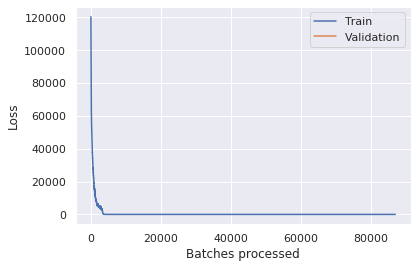

In [29]:
learn.recorder.plot_losses()

In [36]:
preds, _ = learn.get_preds(DatasetType.Test)
# preds[0]

In [52]:
?tabular_learner

In [37]:
y = preds.squeeze().tolist()
y

[0.8904303908348083,
 0.5172987580299377,
 0.5342455506324768,
 1.890610694885254,
 0.9799303412437439,
 0.8545852303504944,
 0.34770408272743225,
 6.496687412261963,
 0.27144935727119446,
 0.3113967776298523,
 0.11772295087575912,
 0.305009663105011,
 0.3537265956401825,
 1.8133795261383057,
 2.519540786743164,
 4.450294017791748,
 0.7149024605751038,
 0.13249588012695312,
 5.049379825592041,
 0.23401416838169098,
 0.6987887620925903,
 0.28519952297210693,
 0.819736123085022,
 0.1644226759672165,
 0.5055296421051025,
 0.15298070013523102,
 0.43497738242149353,
 0.7759799361228943,
 1.670996904373169,
 4.8136467933654785,
 0.43030935525894165,
 3.758139133453369,
 0.4710253179073334,
 0.6243622303009033,
 0.12160173803567886,
 0.5692695379257202,
 0.710156261920929,
 0.5666901469230652,
 0.24241140484809875,
 0.8362144827842712,
 0.24291802942752838,
 0.5657733678817749,
 2.124791145324707,
 0.41540607810020447,
 0.3688799738883972,
 0.9313608407974243,
 0.5485628247261047,
 11.4405155

In [ ]:
y = torch.argmax(preds, dim=1)
y.sum()

In [38]:
INPUT_DIR = "/home/shanmugam/fastai/m5"
submission = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv").pipe(
        reduce_mem_usage
    )

Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [109]:
sub

,date,id,item_id,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,year,month,week,day,dayofweek,is_weekend,demand,sell_price,shift_t28,shift_t29,shift_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t30,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,price_change_t1,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,rolling_skew_t30,rolling_kurt_t30
23141910,2016-04-25,HOBBIES_1_001_CA_1_validation,1438,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,4.0,17.0,25.0,0.0,0.0,8.686046e-26,1.283203,-0.057953,-0.057739,-0.057526,-0.009033,-0.178345,-0.041321,-0.068787,-0.128418,-0.106750,0.001165,-0.233154,-0.041229,0.571777,-0.841797,-0.645508
23141911,2016-04-25,HOBBIES_1_002_CA_1_validation,1439,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,4.0,17.0,25.0,0.0,0.0,1.736995e-25,-0.007603,-0.057953,-0.057739,-0.057526,-0.151489,-0.303955,-0.285645,-0.334229,-0.273682,-0.372803,0.001165,-0.233154,-0.041229,-0.085571,-0.857910,-0.898926
23141912,2016-04-25,HOBBIES_1_003_CA_1_validation,1440,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,4.0,17.0,25.0,0.0,0.0,1.331074e-25,-0.300049,-0.346924,-0.346924,-0.057526,-0.294189,-0.303955,-0.227417,-0.285889,-0.179688,0.035248,0.001165,-0.233154,-0.041229,-0.085571,1.950195,2.210938
23141913,2016-04-25,HOBBIES_1_004_CA_1_validation,1441,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,4.0,17.0,25.0,0.0,0.0,1.747834e-26,0.188354,-0.346924,1.387695,1.388672,0.608887,1.076172,0.284668,0.325195,0.286377,0.574707,0.001165,-0.233154,-0.041229,-0.085571,-0.816895,-0.760254
23141914,2016-04-25,HOBBIES_1_005_CA_1_validation,1442,4,1,1,1,14,2,1,1,0.0,0.0,0.0,2016.0,4.0,17.0,25.0,0.0,0.0,9.780155e-25,-0.326416,-0.057953,-0.346924,-0.346680,-0.151489,0.084045,-0.018127,-0.060638,0.018494,-0.087891,0.001165,-0.233154,-0.041229,-0.085571,-1.038086,-0.732910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995625,2016-05-22,FOODS_3_823_WI_3_validation,1433,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,0.000000e+00,-0.297363,-0.057953,-0.346924,-0.346680,-0.294189,-0.303955,-0.332275,-0.253662,-0.185791,-0.330322,0.001165,-0.233154,-0.041229,-0.085571,0.930664,0.437012
23995626,2016-05-22,FOODS_3_824_WI_3_validation,1434,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,1.061955e-37,-0.443604,-0.346924,-0.057739,-0.346680,-0.341553,-0.372314,-0.297363,-0.374268,-0.394287,-0.339600,0.001165,-0.233154,-0.041229,-0.085571,-0.079285,-0.333984
23995627,2016-05-22,FOODS_3_825_WI_3_validation,1435,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,1.441896e-37,-0.004749,-0.346924,-0.057739,-0.346680,-0.199097,-0.118347,-0.099426,-0.084839,-0.132568,0.017273,0.001165,-0.233154,-0.041229,-0.085571,-0.199951,-0.328125
23995628,2016-05-22,FOODS_3_826_WI_3_validation,1436,3,0,10,3,14,2,1,1,0.0,0.0,0.0,2016.0,5.0,20.0,22.0,6.0,1.0,3.056349e-38,-0.794434,0.520020,-0.057739,0.520996,-0.009033,0.228516,-0.029724,-0.040497,0.079895,0.038727,0.001165,-0.233154,-0.041229,-0.085571,-0.664062,-0.651855


In [39]:
# y = torch.argmax(preds, dim=1)
# y = y[1:]a
# sub = data.iloc[18550276:].copy()
sub['demand'] = y
predictions = sub[['id', 'date', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
for i in range(1,29):
    final['F'+str(i)] *= 1.04
final.to_csv('submission_p.csv', index = False)

In [ ]:
y.sum()

In [ ]:
data = pd.read_feather('/home/shanmugam/fastai/m5/data_min1').pipe(reduce_mem_usage)

In [ ]:
data = reduce_mem_usage(data)

In [ ]:
data.astype('float32', errors='ignore').to_feather('data_min_all')

In [ ]:
%who DataFrame

In [ ]:
INPUT_DIR = "/home/shanmugam/fastai/m5"
data = pd.read_csv(f"{INPUT_DIR}/data.csv").pipe(reduce_mem_usage)

In [ ]:
data = reduce_mem_usage(data)

In [ ]:
len(data['cat_id'].value_counts())

In [ ]:
data[data['year'] > 2013]

In [ ]:
# data = add_agg_features(data)
dt_col = "date"
data = add_time_features(data, dt_col)
data = data.sort_values("date")
data = reduce_mem_usage(data)

In [ ]:
def plot_cv_indices(cv, X, y, dt_col, ax, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    n_splits = cv.get_n_splits()
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Datetime",
        ylabel="CV iteration",
        xlim=[X[dt_col].min(), X[dt_col].max()],
    )
    ax.invert_yaxis()
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, dt_col="date"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.dt_col = dt_col

    def split(self, X, y=None, groups=None):
        sec = (X[self.dt_col] - X[self.dt_col][0]).dt.total_seconds()
        duration = sec.max() - sec.min()

        train_sec = 3600 * 24 * self.train_days
        test_sec = 3600 * 24 * self.test_days
        total_sec = test_sec + train_sec
        step = (duration - total_sec) / (self.n_splits - 1)

        train_start = 0
        for idx in range(self.n_splits):
            train_start = idx * step
            train_end = train_start + train_sec
            test_end = train_end + test_sec

            if idx == self.n_splits - 1:
                test_mask = sec >= train_end
            else:
                test_mask = (sec >= train_end) & (sec < test_end)

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = (sec >= train_end) & (sec < test_end)

            yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
cv_params = {
    "n_splits": 5,
    "train_days": 300,
    "test_days": 28,
    "dt_col": dt_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)
plot_cv_indices(cv, data.iloc[::100, :].reset_index(drop=True), None, dt_col, ax)

In [ ]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # aggregation features.
    "shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_mean_t7",
    "rolling_std_t7",
    "rolling_mean_t30",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_std_t30",
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    "rolling_skew_t30",
    "rolling_kurt_t30"
]

# prepare training and test data.
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

mask = data["date"] <= "2016-04-24"
X_train = data[mask][["date"] + features].reset_index(drop=True)
y_train = data[mask]["demand"].reset_index(drop=True)
X_test = data[~mask][features].reset_index(drop=True)

# keep these two columns to use later.
id_date = data[~mask][["id", "date"]].reset_index(drop=True)

del data
gc.collect()

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

In [ ]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n---------- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) ----------\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(X_trn.drop(drop_when_train, axis=1), label=y_trn)
        val_set = lgb.Dataset(X_val.drop(drop_when_train, axis=1), label=y_val)

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
        )
        models.append(model)

    return models

In [ ]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "objective": "regression",
    "n_jobs": -1,
    "seed": 42,
    "learning_rate": 0.1,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

# cv = TimeSeriesSplit(n_splits=5)
models = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=[dt_col]
)

del X_train, y_train
gc.collect()

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
imp_type = "gain"
importances = np.zeros(X_test.shape[1])
preds = np.zeros(X_test.shape[0])

for model in models:
    preds += model.predict(X_test)
    importances += model.feature_importance(imp_type)

# Take the average over folds.
preds = preds / cv.get_n_splits()
importances = importances / cv.get_n_splits()

https://github.com/harupy/mlflow-extend

In [ ]:
from mlflow_extend import mlflow, plotting as mplt

with mlflow.start_run():
    mlflow.log_params_flatten({"bst": bst_params, "fit": fit_params, "cv": cv_params})


features = models[0].feature_name()
_ = mplt.feature_importance(features, importances, imp_type, limit=30)

In [ ]:
def make_submission(test, submission):
    preds = test[["id", "date", "demand"]]
    preds = pd.pivot(preds, index="id", columns="date", values="demand").reset_index()
    F_cols = ["F" + str(x + 1) for x in range(28)]
    preds.columns = ["id"] + F_cols

    evals = submission[submission["id"].str.endswith("evaluation")]
    vals = submission[["id"]].merge(preds, how="inner", on="id")
    final = pd.concat([vals, evals])

    assert final[F_cols].isnull().sum().sum() == 0
    assert final["id"].equals(submission["id"])

    final.to_csv("submission.csv", index=False)

In [ ]:
make_submission(id_date.assign(demand=preds), submission)